# Variational AutoEncoders (VAE)의 이해와 구현

## 1. 생성 모델의 개요

### 1.1 생성 모델 개요

- 이미지 생성 모델은 잠재 공간에서 샘플링하여 완전히 새로운 이미지나 기존 이미지를 변형시키는 기술입니다.

- 주요 기법으로는 Variational AutoEncoders (VAE)와 Generative Adversarial Networks (GAN)이 있습니다.

### 1.2 VAE와 GAN 비교

- VAE: 입력 이미지를 잠재 공간의 확률 분포로 인코딩하고, 이 분포에서 샘플을 추출하여 이미지를 생성합니다. 안정적인 학습이 가능하며 잠재 공간에서의 연속성을 보장합니다.

- GAN: 생성자와 판별자가 경쟁적으로 학습하여 실제와 유사한 이미지를 생성합니다. 고품질의 이미지를 생성할 수 있지만 학습이 불안정할 수 있습니다.

## 2. 잠재 공간(Latent Space)의 개념

- 잠재 공간은 고차원의 데이터를 저차원 공간으로 압축한 공간으로, 데이터의 중요한 특징을 보존합니다.

- VAE는 잠재 공간을 확률 분포로 모델링하여 연속적인 공간에서 샘플링이 가능합니다.

<img src='https://ars.els-cdn.com/content/image/1-s2.0-S2666389920301902-gr3.jpg'>

## 3. 변이형 오토인코더(VAE) 설명

### 3.1 VAE 아키텍처
VAE는 인코더와 디코더로 구성됩니다.

- 인코더: 입력 데이터를 잠재 공간의 확률 분포의 파라미터(평균과 분산)로 변환합니다.
- 디코더: 잠재 변수z를 입력받아 원본 데이터와 유사한 데이터를 생성합니다.

### 3.2 재매개변수화 트릭(Reparameterization Trick)

잠재 변수 z를 샘플링하는 과정에서 미분이 불가능한 문제를 해결하기 위해 사용됩니다.

- z=μ+σ⊙ϵ
- 여기서 ϵ∼N(0,I)

### 3.3 VAE의 훈련 과정

훈련은 두 가지 손실을 최소화하는 방향으로 진행됩니다.

1. 재구성 손실(Reconstruction Loss): 디코더의 출력이 입력과 얼마나 유사한지 측정합니다.
2. 정규화 손실(Regularization Loss): 잠재 변수의 분포가 표준 정규분포를 따르도록 유도합니다. 이는 Kullback-Leibler Divergence(KL 발산)을 사용합니다.

    ```
    z_mean, z_log_var = encoder(input_img)

    z = z_mean + exp(0.5 * z_log_var) * epsilon

    recontructed_img = decoder(z)

    model = Model(input_img, reconstructed_img)

    재구성 손실과 규제 손실을 사용하여 훈련
    ```

<img src='https://image.slidesharecdn.com/variationalautoencoder-170601084514/95/variational-autoencoder-21-638.jpg?cb=1496306885'>

## 4. VAE 구현

### 4.1 필요한 라이브러리 import, 환경 설정 및 데이터 준비

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# 환경 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCHS = 10
LATENT_DIM = 2

In [ ]:
# 데이터 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 4.2 인코더 구현

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(64 * 7 * 7, 16)
        self.z_mean = nn.Linear(16, latent_dim)
        self.z_log_var = nn.Linear(16, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.dense(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var

1. 첫 번째 레이어: 1채널 → 32채널 (28x28 → 14x14)
2. 두 번째 레이어: 32채널 → 64채널 (14x14 → 7x7)
3. Feature Map을 Flatten 후 16차원으로 압축
4. 평균(z_mean)과 로그 분산(z_log_var) 계산

### 4.3 디코더 구현

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense = nn.Linear(latent_dim, 7*7*32)
        self.conv_transpose1 = nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv_transpose3 = nn.ConvTranspose2d(32, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.dense(x))
        x = x.view(-1, 32, 7, 7)
        x = F.relu(self.conv_transpose1(x))
        x = F.relu(self.conv_transpose2(x))
        x = torch.sigmoid(self.conv_transpose3(x))
        return x

1. 전치 컨볼루션(디컨볼루션) 구조

    - 잠재 벡터 → 7x7x32 특징 맵
    - 점진적으로 해상도를 증가시켜 원본 크기로 복원

2. output_padding은 홀수 차원에서 정확한 업샘플링을 위해 필요

### 4.4 VAE 모델 통합

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

1. 재매개변수화 트릭

    - 확률적 샘플링을 미분 가능하게 만듦
    - 학습 중 그래디언트 전파를 가능하게 함


2. 모델 흐름
    - 입력 → 인코더 → 잠재 벡터 샘플링 → 디코더 → 재구성

### 4.5 손실 함수 정의

In [ ]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

1. 재구성 손실 (BCE)
    - 원본과 재구성 이미지 간의 차이 측정

2. KL 발산 (KLD)
    - 잠재 공간이 정규분포를 따르도록 작업
    - 잠재 공간의 연속성 보장

### 4.6 Train 함수 정의

In [ ]:
def train_with_visualization(model, train_loader, test_loader, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    visualizer = TrainingVisualizer(model, device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var = model(data)
            loss = loss_function(recon_batch, data, mu, log_var)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

        # 매 에포크마다 이미지 생성 및 저장
        visualizer.save_generated_images(epoch)

        # 5 에포크마다 잠재 공간 시각화
        if epoch % 5 == 0:
            visualizer.visualize_latent_space(test_loader)
            visualizer.interpolate_latent_space()

        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

    # 학습 완료 후 애니메이션 생성
    visualizer.create_training_animation()

    # 최종 시각화
    visualizer.visualize_latent_space(test_loader)
    visualizer.interpolate_latent_space()

### 4.7 시각화 함수 정의

In [ ]:
class TrainingVisualizer:
    def __init__(self, model, device, latent_dim=2):
        self.model = model
        self.device = device
        self.latent_dim = latent_dim
        self.generated_images = []

        # 결과 저장을 위한 디렉토리 생성
        os.makedirs('training_progress', exist_ok=True)

    def save_generated_images(self, epoch):
        """각 에포크마다 생성된 이미지 저장"""
        self.model.eval()
        with torch.no_grad():
            # 16x16 그리드의 이미지 생성
            sample = torch.randn(16*16, self.latent_dim).to(self.device)
            generated = self.model.decoder(sample).cpu()

            fig = plt.figure(figsize=(10, 10))
            for i in range(16*16):
                plt.subplot(16, 16, i+1)
                plt.imshow(generated[i][0], cmap='gray')
                plt.axis('off')

            # 이미지 저장
            plt.savefig(f'training_progress/epoch_{epoch}.png')
            plt.close()

            # 나중에 GIF 생성을 위해 이미지 저장
            self.generated_images.append(f'training_progress/epoch_{epoch}.png')

    def create_training_animation(self):
        """저장된 이미지들을 사용하여 GIF 생성"""
        import imageio

        images = []
        for filename in self.generated_images:
            images.append(imageio.imread(filename))

        # GIF 저장
        imageio.mimsave('training_progress/training_animation.gif',
                       images, fps=2)

    def visualize_latent_space(self, test_loader, num_samples=1000):
        """잠재 공간 시각화"""
        self.model.eval()
        test_samples = []
        test_labels = []

        with torch.no_grad():
            for data, labels in test_loader:
                if len(test_samples) * data.shape[0] >= num_samples:
                    break
                data = data.to(self.device)
                mu, _ = self.model.encoder(data)
                test_samples.append(mu.cpu().numpy())
                test_labels.extend(labels.numpy())

        test_samples = np.concatenate(test_samples, axis=0)[:num_samples]
        test_labels = np.array(test_labels)[:num_samples]

        # 산점도 생성
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(test_samples[:, 0], test_samples[:, 1],
                            c=test_labels, cmap='tab10')
        plt.colorbar(scatter)
        plt.title('Latent Space Distribution')
        plt.xlabel('First Latent Dimension')
        plt.ylabel('Second Latent Dimension')
        plt.savefig('training_progress/latent_space.png')
        plt.close()

    def interpolate_latent_space(self, num_points=20):
        """잠재 공간 보간"""
        self.model.eval()
        with torch.no_grad():
            # 격자 생성
            x = np.linspace(-3, 3, num_points)
            y = np.linspace(-3, 3, num_points)
            xx, yy = np.meshgrid(x, y)

            # 격자점들을 잠재 벡터로 변환
            grid_points = np.column_stack((xx.ravel(), yy.ravel()))
            grid_points_tensor = torch.FloatTensor(grid_points).to(self.device)

            # 이미지 생성
            decoded_images = self.model.decoder(grid_points_tensor)

            # 결과 시각화
            plt.figure(figsize=(15, 15))
            for i in range(num_points**2):
                plt.subplot(num_points, num_points, i+1)
                plt.imshow(decoded_images[i][0].cpu(), cmap='gray')
                plt.axis('off')

            plt.savefig('training_progress/latent_space_interpolation.png')
            plt.close()

1. TrainingVisualizer 클래스

- 학습 과정의 시각화를 관리하는 클래스
- 생성된 이미지 저장
- GIF 애니메이션 생성
- 잠재 공간 시각화
- 잠재 공간 보간 시각화


2. 시각화 기능

- save_generated_images: 각 에포크마다 생성된 이미지를 16x16 그리드로 저장
- create_training_animation: 저장된 이미지들을 사용하여 GIF 생성
- visualize_latent_space: 2D 잠재 공간에서 테스트 데이터의 분포를 시각화
- interpolate_latent_space: 잠재 공간의 격자점에서 이미지 생성

3. 결과물

- 최종 생성 이미지 (epoch_10.png)
- 학습 과정 애니메이션 (training_animation.gif)
- 잠재 공간 분포 (latent_space.png)
- 잠재 공간 보간 결과 (latent_space_interpolation.png)

### 4.8 모델 초기화 및 학습

In [ ]:
# 모델 초기화 및 학습 실행
model = VAE(LATENT_DIM).to(device)
train_with_visualization(model, train_loader, test_loader)

# 결과 표시
print("Training completed! Generated visualizations:")
print("\n1. Final generated images: training_progress/epoch_10.png")
print("2. Training animation: training_progress/training_animation.gif")
print("3. Latent space visualization: training_progress/latent_space.png")
print("4. Latent space interpolation: training_progress/latent_space_interpolation.png")

Train Epoch: 1 [0/60000 (0%)]	Loss: 657.266052
Train Epoch: 1 [6400/60000 (11%)]	Loss: 208.588760
Train Epoch: 1 [12800/60000 (21%)]	Loss: 193.297821
Train Epoch: 1 [19200/60000 (32%)]	Loss: 182.092865
Train Epoch: 1 [25600/60000 (43%)]	Loss: 180.579529
Train Epoch: 1 [32000/60000 (53%)]	Loss: 177.041534
Train Epoch: 1 [38400/60000 (64%)]	Loss: 181.934540
Train Epoch: 1 [44800/60000 (75%)]	Loss: 175.467850
Train Epoch: 1 [51200/60000 (85%)]	Loss: 169.706207
Train Epoch: 1 [57600/60000 (96%)]	Loss: 178.795258
====> Epoch: 1 Average loss: 196.4757
Train Epoch: 2 [0/60000 (0%)]	Loss: 168.997391
Train Epoch: 2 [6400/60000 (11%)]	Loss: 163.888519
Train Epoch: 2 [12800/60000 (21%)]	Loss: 166.652969
Train Epoch: 2 [19200/60000 (32%)]	Loss: 167.892181
Train Epoch: 2 [25600/60000 (43%)]	Loss: 176.133453
Train Epoch: 2 [32000/60000 (53%)]	Loss: 168.807938
Train Epoch: 2 [38400/60000 (64%)]	Loss: 172.878799
Train Epoch: 2 [44800/60000 (75%)]	Loss: 170.829224
Train Epoch: 2 [51200/60000 (85%)]	Los

<ipython-input-8-c57d3d0cd9bf>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Training completed! Generated visualizations:

1. Final generated images: training_progress/epoch_10.png
2. Training animation: training_progress/training_animation.gif
3. Latent space visualization: training_progress/latent_space.png
4. Latent space interpolation: training_progress/latent_space_interpolation.png


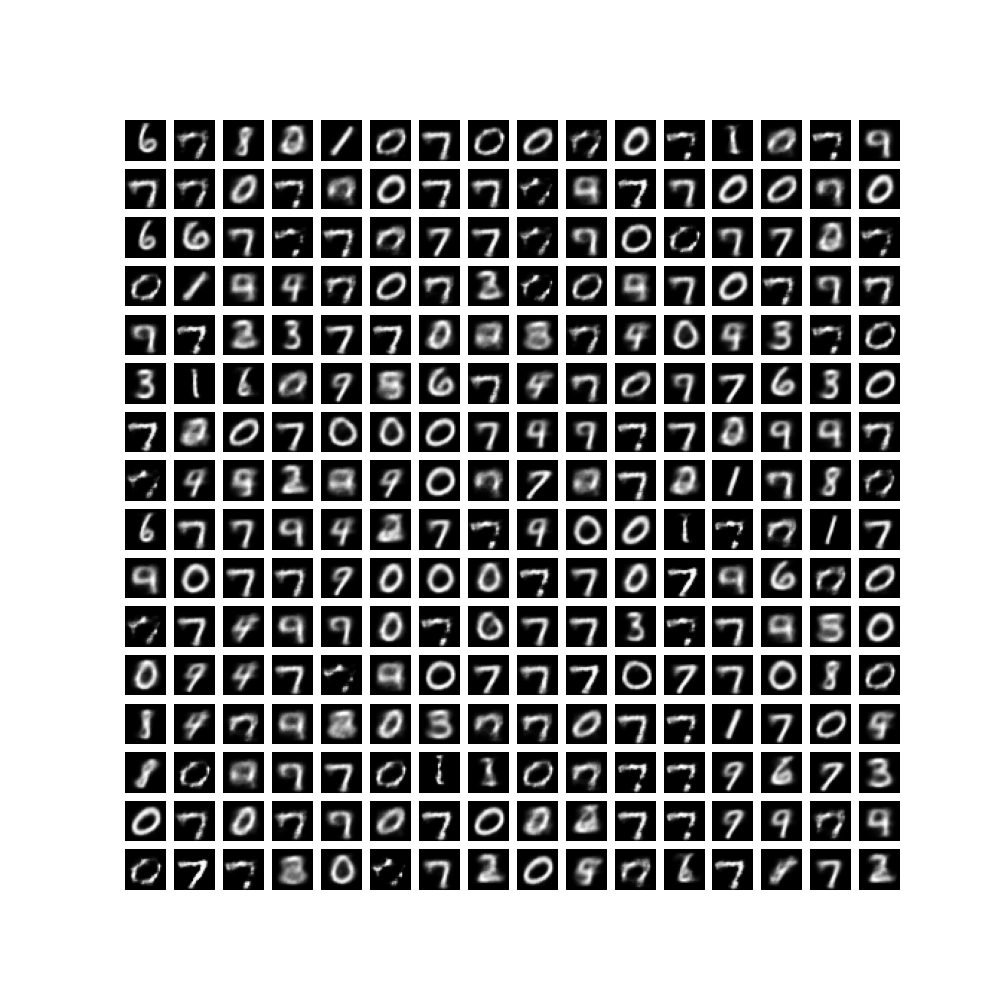

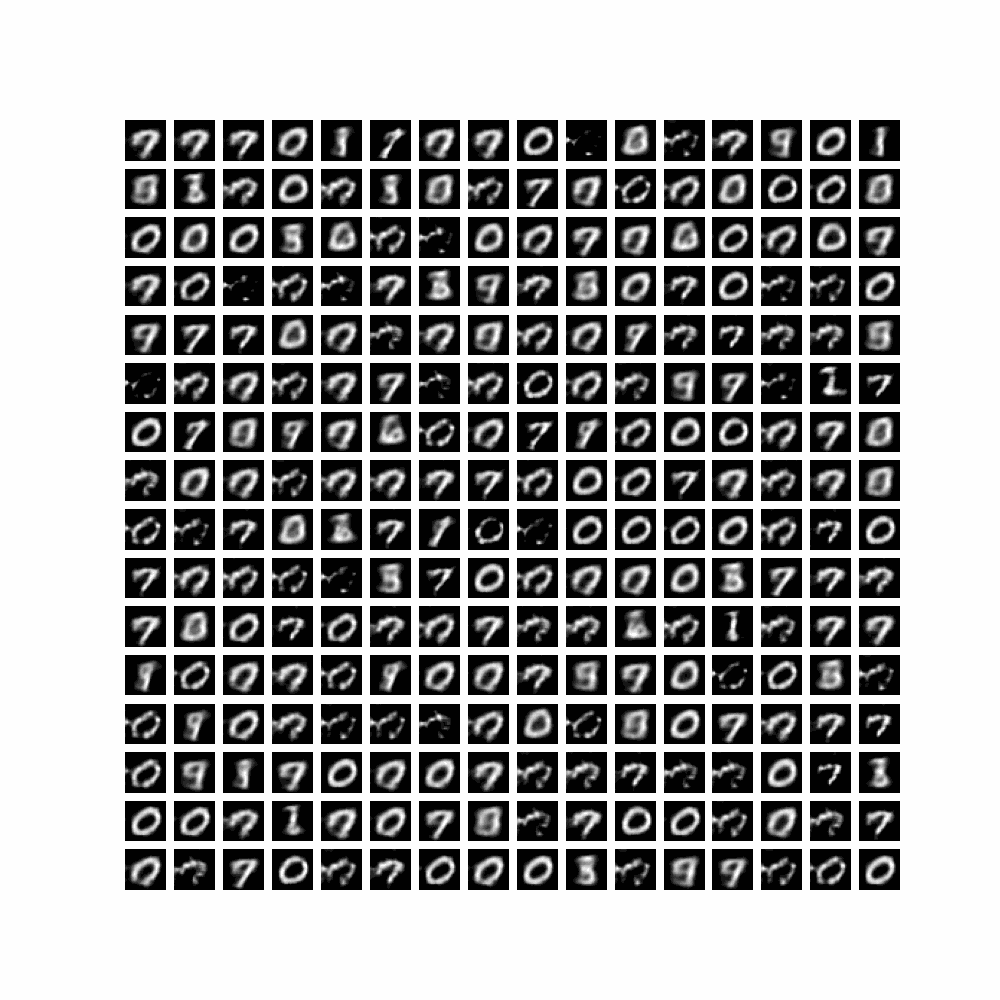

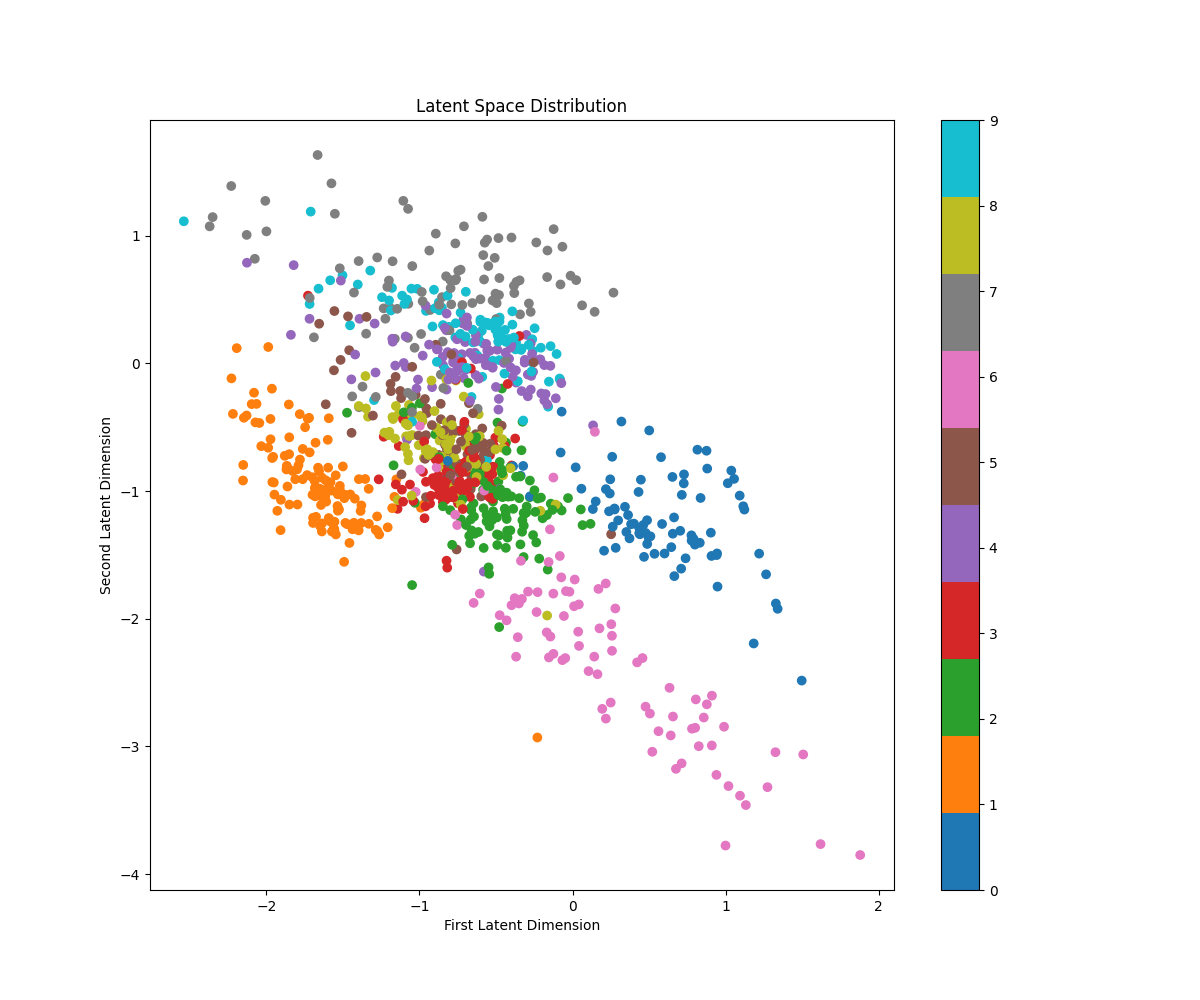

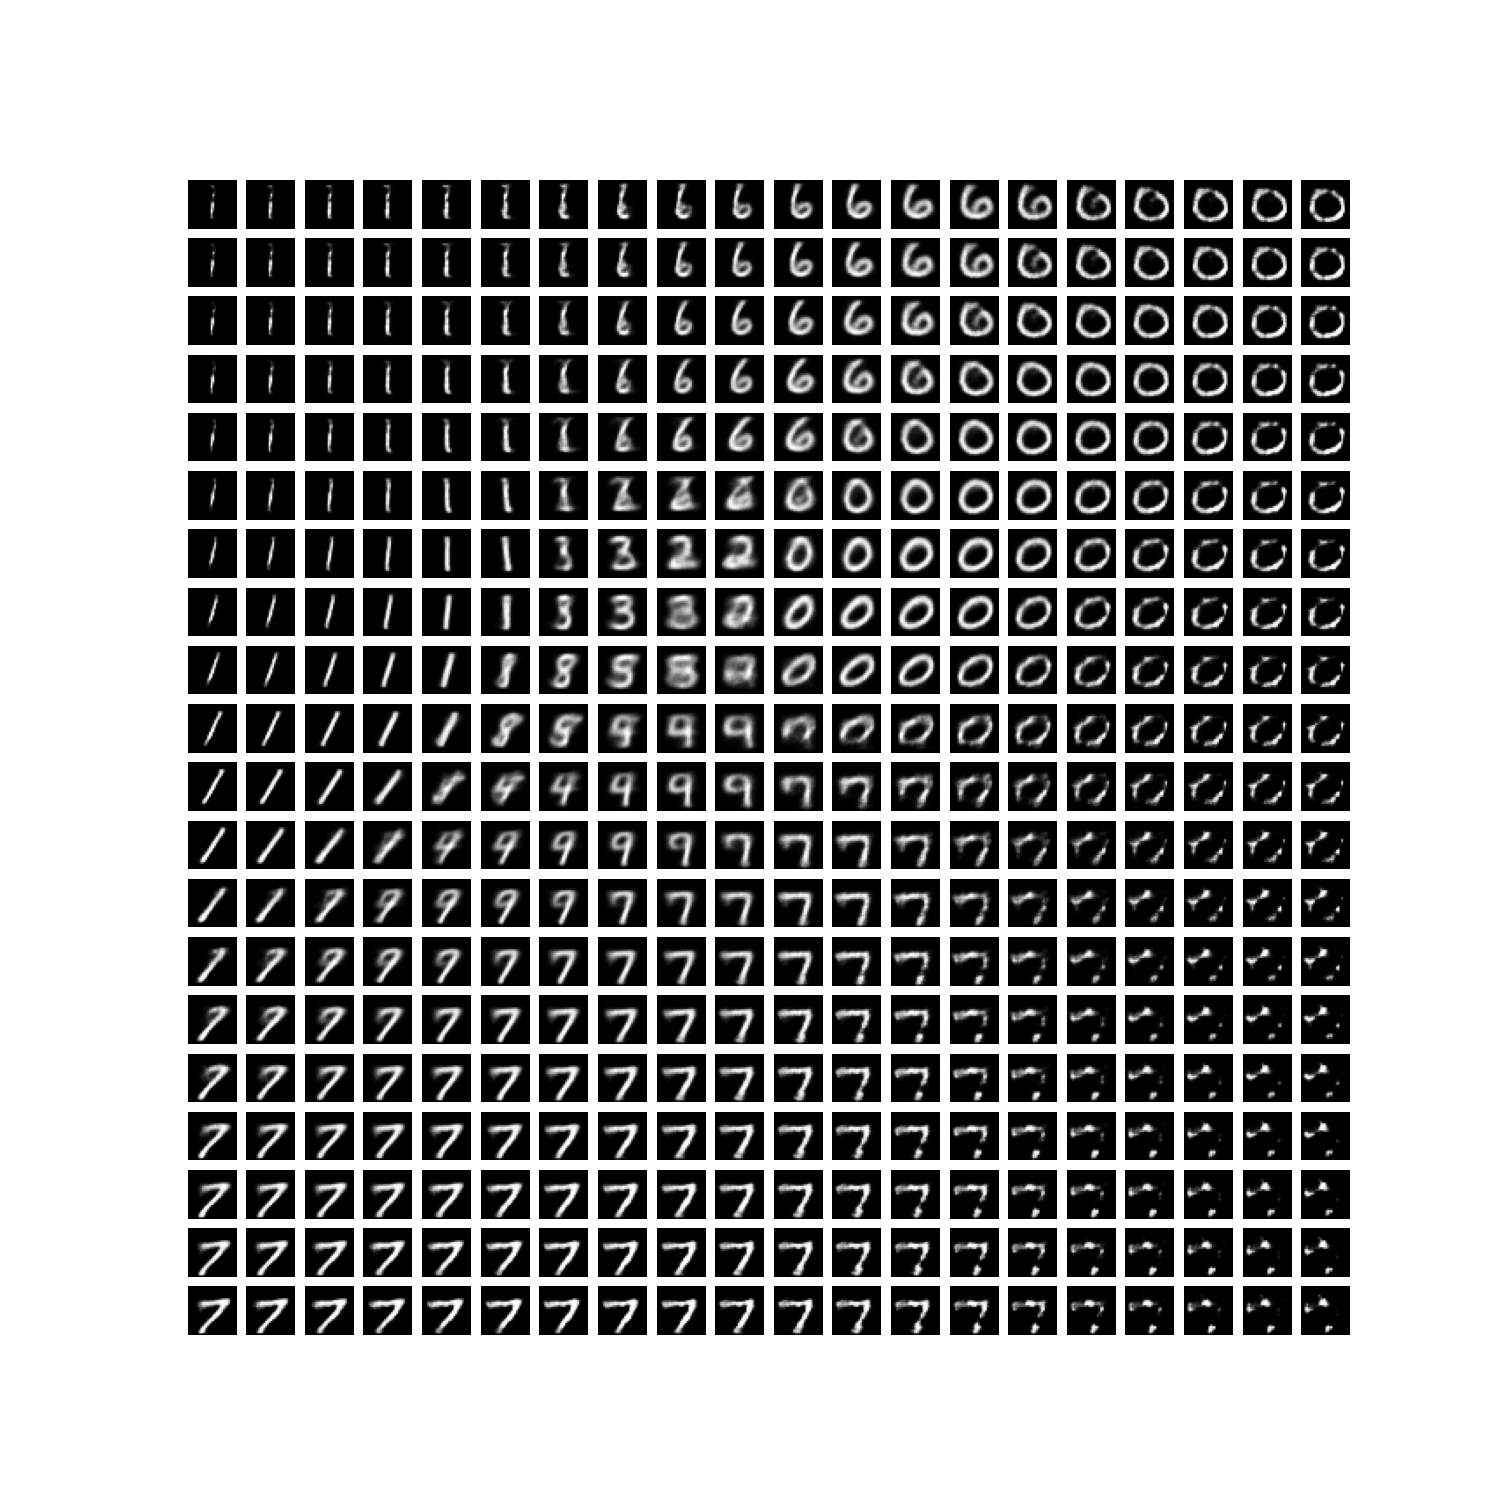

In [ ]:
# Jupyter notebook에서 결과 표시
from IPython.display import Image, display

display(Image(filename='training_progress/epoch_10.png'))
display(Image(filename='training_progress/training_animation.gif'))
display(Image(filename='training_progress/latent_space.png'))
display(Image(filename='training_progress/latent_space_interpolation.png'))

위의 코드로 학습 과정에서 다음과 같은 시각화가 생성됩니다.

1. 각 에포크마다 생성된 이미지들
2. 전체 학습 과정을 보여주는 애니메이션
3. 숫자들이 잠재 공간에서 어떻게 분포하는지 보여주는 산점도
4. 잠재 공간의 다양한 지점에서 생성된 이미지들의 격자

### 4.10 모델 저장

In [ ]:
# 모델 저장
torch.save(model.state_dict(), 'vae.pth')

### 실습 / 탐구

- latent_dim의 값을 변경하여 생성되는 이미지의 다양성과 품질이 어떻게 변하는지 실험해보세요. (단, Epoch는 늘리지 마세요. 컴퓨팅 리소스가 아깝습니다..)

- 만약에 해당 분야에 관심이 있으시다면, Fashion MNIST나 CIFAR-10 등의 다른 데이터셋으로 VAE를 구현해보세요.

## Reference

- [Autoencoder 와 Variational Autoencoder의 직관적인 이해](https://medium.com/@hugmanskj/autoencoder-%EC%99%80-variational-autoencoder%EC%9D%98-%EC%A7%81%EA%B4%80%EC%A0%81%EC%9D%B8-%EC%9D%B4%ED%95%B4-171b3968f20b)